**Purpose:** Extract the details about the current resources in the Galaxy Training Material and some statistics

In [34]:
import base64
import copy
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import seaborn as sns
import time
import yaml

from dateutil import relativedelta
from matplotlib.collections import PatchCollection

from github import Github
from pathlib import Path
from pprint import pprint

Usage:
1. Generate a Personal access tokens on GitHub (in Setting)
2. Add it to the `../config.yaml` after `github:`

In [2]:
with open("../config.yaml", "r") as stream:
    config = yaml.load(stream, Loader=yaml.FullLoader)

In [3]:
# connect to GitHub
g = Github(config["github"])
# to get limit of API request: g.get_rate_limit()
# retrieve the hub repository
repo = g.get_user("galaxyproject").get_repo("training-material")

Extraction date

In [4]:
str(datetime.datetime.now())

'2020-12-22 15:58:04.509962'

In [5]:
# create range for every month
delta = 1
start = datetime.datetime(year=2016, month=8, day=1)
new_struct_start = datetime.datetime(year=2017, month=5, day=15) # before it was a different structure (difficult to extract anything)
contr_start = datetime.datetime(year=2017, month=9, day=6) # before no contributors.yaml
end = datetime.datetime.now()
r = relativedelta.relativedelta(end, start)
month_nb = 12*r.years + r.months
months = pd.date_range(start, periods=month_nb, freq='M')
month_idx = pd.PeriodIndex(months)

Number of months for the extraction

In [6]:
len(months)

52

In [7]:
# get commit sha of latest commit before beginning of each month
commits = pd.DataFrame({'date': months, 'commit': None}, index=month_idx)
for idx in commits.index:
    m = commits['date'][idx]
    commits['commit'][idx] = repo.get_commits(since=m-relativedelta.relativedelta(months=1),until=m)[0].sha
commits.head()

/Users/bebatut/miniconda3/envs/gtn-community-paper-2020/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,date,commit
2016-08,2016-08-31,4e559ab35e31383c2a259a3b4f236c2e4f331889
2016-09,2016-09-30,26e89f597f762e3754a50315cc9c3c2f7dec1e2d
2016-10,2016-10-31,91a8709d16e0dfa760bd3d647aa155fbf4e14bf0
2016-11,2016-11-30,031173f6f807321f31cc5b088ea9991680a4ee1e
2016-12,2016-12-31,2fa85dc7d6c5186d62ab72ba563cb539ee4c6039


# Evolution of topics, tutorials and technical support

In [8]:
def has_zenodo(file_content):
    '''
    Check if Zenodo link in tutorial

    :param file_content: the encoded content of the file obtained with GitHub API

    :return: boolean
    '''
    decoded_file_content = base64.b64decode(file_content)
    return 'zenodo_link' in str(decoded_file_content)


def is_enable(file_content):
    '''
    Check if tutorial is enabled or not link in tutorial

    :param file_content: the encoded content of the file obtained with GitHub API

    :return: boolean
    '''
    decoded_file_content = base64.b64decode(file_content)
    return not 'enable: ' in str(decoded_file_content)


def get_topic_title(topic_n, ref):
    '''
    :param topic_n: name of the topic
    :param ref: name of the commit/branch/tag
    
    :return: title of the topic in metadata file
    '''
    metadata_f = repo.get_contents("topics/%s/metadata.yaml" % topic_n, ref)
    metadata_f_content = yaml.load(base64.b64decode(metadata_f.content), Loader=yaml.FullLoader)
    return metadata_f_content['title']
    

def extract_training_content(ref, date):
    '''
    Extract the details about the current resources in the Galaxy Training Material,
    and aggregate information per topics

    :param ref: name of the commit/branch/tag
    :param date: 

    :return: aggregated statistics per topics
    '''
    trainings = {}
    topics_dir = "topics"
    infos = {'workflows': False, 'zenodo': False}
    stat_c = {'introduction': 0, 'tutorials': 0, 'workflows': 0, 'zenodo': 0}
    stats = pd.DataFrame(columns=list(stat_c.keys()), index=[])
    if date >= new_struct_start:
        for topic in repo.get_contents("topics", ref):
            # get topic details
            topic_n = topic.name
            #print(topic_n)
            topic_t = get_topic_title(topic_n, ref)
            # prepare aggregation for topic
            trainings.setdefault(topic_n, {})
            topic_stat = copy.copy(stat_c)
            # check for introduction
            has_tuto_folder = False
            for topic_c in repo.get_contents("%s/" % topic.path, ref):
                if topic_c.name == 'slides':
                    topic_stat['introduction'] += len(
                        repo.get_contents("%s/slides/" % topic.path, ref))
                if topic_c.name == 'tutorials':
                    has_tuto_folder = True
            if not has_tuto_folder:
                continue
            # parse the tutorials
            for tuto in repo.get_contents("%s/tutorials/" % topic.path, ref):
                tuto_n = tuto.name
                if '.md' in tuto_n:
                    continue
                #print(tuto_n)
                enabled = True
                trainings[topic_n].setdefault(tuto_n, copy.copy(infos))
                # parse the files in the tuto folder
                for tuto_f in repo.get_contents(tuto.path, ref):
                    if tuto_f.name == 'tutorial.md':
                        enabled = is_enable(tuto_f.content)
                        trainings[topic_n][tuto_n]['zenodo'] = has_zenodo(tuto_f.content)
                    elif tuto_f.name == 'slides.html':
                        enabled = is_enable(tuto_f.content)
                    elif tuto_f.name == 'workflows':
                        trainings[topic_n][tuto_n]['workflows'] = True
                # aggregate stats if enable tutorial
                if enabled:
                    topic_stat['tutorials'] += 1
                    for c in topic_stat:
                        if c == 'tutorials' or c == 'introduction':
                            continue
                        if trainings[topic_n][tuto_n][c]:
                            topic_stat[c] += 1
            # add stats in table
            stats.loc[topic_t] = topic_stat
    else:
        print("Not extracted")
    # rename table columns
    stats = stats.rename(columns = {
        'introduction': 'Introduction slide decks',
        'tutorials': 'Tutorials',
        'workflows': 'Workflows',
        'zenodo': 'Data on Zenodo'})
    return stats    

In [24]:
# extract training content
global_stats_fp = Path('..') / Path('results') / Path('repo_content_global_stats.csv')
if global_stats_fp.is_file():
    global_stats = pd.read_csv(global_stats_fp, index_col=0)
    global_stats.index = commits.index[:len(global_stats.index)]
else:
    global_stats = pd.DataFrame(columns=['Topics', 'Introduction slide decks', 'Tutorials', 'Workflows', 'Data on Zenodo'],
                                index=commits.index)

In [26]:
# extract training content
# to avoid API request limit issue, 
# - extract few months until the remaining API rate limit is below a threshold 
# - wait for one hour
# - repeat
api_rate_limit = 500
date_format = '%Y-%m'
for idx in commits.index:
    d = commits['date'][idx]
    git_com = commits['commit'][idx]
    print(d)
    print(git_com)
    # check if need to extract
    if d < new_struct_start:
        print("Not extracted: before new structure")
        print()
        continue
    if idx in global_stats.index:#or pd.notnull(global_stats['Tutorials'][idx]):
        print("Already extracted")
        print()
        continue
    if g.get_rate_limit().core.remaining < api_rate_limit:
        print("WAITING for 1 hour to retrieve GitHub API request access !!!")
        print()
        time.sleep(60*60)
    # extract content
    stats_per_date = extract_training_content(git_com, d)
    # summarize
    aggr_stats = stats_per_date.sum()
    for i in aggr_stats.index:
        global_stats[i][idx] = aggr_stats[i]
    global_stats['Topics'][idx] = len(stats_per_date)
    # save into csv
    global_stats.to_csv(global_stats_fp)
    print(g.get_rate_limit())
    print()

2016-08-31 00:00:00
4e559ab35e31383c2a259a3b4f236c2e4f331889
Not extracted: before new structure

2016-09-30 00:00:00
26e89f597f762e3754a50315cc9c3c2f7dec1e2d
Not extracted: before new structure

2016-10-31 00:00:00
91a8709d16e0dfa760bd3d647aa155fbf4e14bf0
Not extracted: before new structure

2016-11-30 00:00:00
031173f6f807321f31cc5b088ea9991680a4ee1e
Not extracted: before new structure

2016-12-31 00:00:00
2fa85dc7d6c5186d62ab72ba563cb539ee4c6039
Not extracted: before new structure

2017-01-31 00:00:00
26a44347215b6d67677a60be8ba9c86e7c4d36bc
Not extracted: before new structure

2017-02-28 00:00:00
eebd606f0e7a38e9fa7dfb6a6a53c9a1109f982e
Not extracted: before new structure

2017-03-31 00:00:00
96423195d1423d57e544205ca8b9c127295df06b
Not extracted: before new structure

2017-04-30 00:00:00
6951fd662d031017181bf8846a1b90bad211b1b7
Not extracted: before new structure

2017-05-31 00:00:00
3d3bde4c8abea148b151f7a984a7a791a354353b
Already extracted

2017-06-30 00:00:00
a1c462853e7802db1f

Global informations

<Figure size 432x288 with 0 Axes>

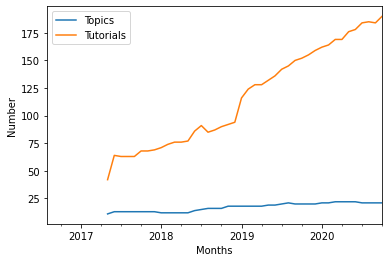

In [27]:
content_stats = global_stats[['Topics', 'Tutorials']]
plt.figure()
content_stats.plot()
plt.xlabel('Months')
plt.ylabel('Number')
plt.show()

Topics, number of tutorials and technical support (today)

In [28]:
stat = (pd.DataFrame(extract_training_content(commits['commit'][-1], commits['date'][-1]))
        .astype(int))
stat

,Introduction slide decks,Tutorials,Workflows,Data on Zenodo
Galaxy Server administration,1,34,0,9
Assembly,0,5,5,5
Climate,1,2,0,2
Computational chemistry,0,6,5,6
Contributing to the Galaxy Training Material,1,11,1,3
Development in Galaxy,1,13,0,0
Ecology,0,6,6,5
Epigenetics,2,6,5,6
User Interface and Data Manipulation,0,16,2,15
Genome Annotation,1,3,3,3


In [29]:
stat = stat.reindex(["Introduction to Galaxy Analyses",
              "Assembly",
              "Climate",
              "Computational chemistry",
              "Ecology",
              "Epigenetics",
              "Genome Annotation",
              "Imaging",
              "Metabolomics",
              "Metagenomics",
              "Proteomics",
              "Sequence analysis",
              "Statistics and machine learning",
              "Transcriptomics",
              "Variant Analysis",
              "Visualisation",
              "User Interface and Data Manipulation",
              "Galaxy Server administration",
              "Development in Galaxy",
              "Contributing to the Galaxy Training Material",
              "Teaching and Hosting Galaxy training"])

In [30]:
topic_index = ["Introduction to Galaxy Analyses",
              "Assembly",
              "Climate",
              "Computational chemistry",
              "Ecology",
              "Epigenetics",
              "Genome Annotation",
              "Imaging",
              "Metabolomics",
              "Metagenomics",
              "Proteomics",
              "Sequence analysis",
              "Statistics and machine learning",
              "Transcriptomics",
              "Variant Analysis",
              "Visualisation",
              "User Interface and Data Manipulation",
              "Galaxy Server administration",
              "Development in Galaxy",
              "Contributing to the Galaxy Training Material",
              "Teaching and Hosting Galaxy training"]
topic_index.reverse()
topic_index

['Teaching and Hosting Galaxy training',
 'Contributing to the Galaxy Training Material',
 'Development in Galaxy',
 'Galaxy Server administration',
 'User Interface and Data Manipulation',
 'Visualisation',
 'Variant Analysis',
 'Transcriptomics',
 'Statistics and machine learning',
 'Sequence analysis',
 'Proteomics',
 'Metagenomics',
 'Metabolomics',
 'Imaging',
 'Genome Annotation',
 'Epigenetics',
 'Ecology',
 'Computational chemistry',
 'Climate',
 'Assembly',
 'Introduction to Galaxy Analyses']

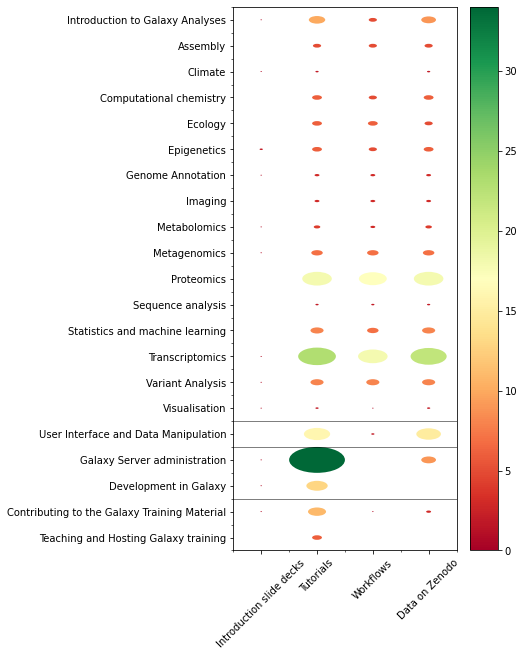

In [35]:
fig, ax = plt.subplots(figsize=(5, 10))

N, M = stat.shape
x, y = np.meshgrid(np.arange(M), np.arange(N))
data = stat.reindex(topic_index)
s = data.to_numpy()
radius = s/s.max()/2
val = data.values.flatten()
circles = [plt.Circle((j,i), radius=r) for r, j, i in zip(radius.flat, x.flat, y.flat)]
col = PatchCollection(circles, array=val, cmap="RdYlGn")
ax.add_collection(col)

ax.set(xticks=np.arange(M),
       yticks=np.arange(N),
       xticklabels=data.columns,
       yticklabels=data.index)
ax.set_xticks(np.arange(M+1)-0.5, minor=True)
ax.set_yticks(np.arange(N+1)-0.5, minor=True)
#ax.grid(which='minor')
plt.xticks(rotation=45)
plt.axhline(1.5, color='black', linewidth=0.5)
plt.axhline(3.5, color='black', linewidth=0.5)
plt.axhline(4.5, color='black', linewidth=0.5)

fig.colorbar(col)
plt.show()

# Contributors

In [37]:
def get_contributors(ref):
    '''
    Extract the list of contributor at a given git commit

    :param ref: name of the commit/branch/tag

    :return: set with contributor ids
    '''
    file_content = repo.get_contents("CONTRIBUTORS.yaml", ref=ref).content
    decoded_file_content = base64.b64decode(file_content)
    yaml_content = yaml.load(decoded_file_content, Loader=yaml.FullLoader)
    contributors = set(yaml_content.keys())
    return contributors

In [38]:
contributor_stats = pd.DataFrame(columns=['Contributors'], index=month_idx)
for idx in commits.index:
    d = commits['date'][idx]
    git_com = commits['commit'][idx]
    print(d)
    print(git_com)
    if d < contr_start:
        print("Not extracted: before CONTRIBUTORS.yaml")
        print()
        continue
    if pd.notnull(contributor_stats['Contributors'][idx]):
        print("Already extracted")
        print()
        continue
    if g.get_rate_limit().core.remaining < api_rate_limit:
        print("WAITING for 1 hour to retrieve GitHub API request access !!!")
        print()
        time.sleep(60*60)
    contributor_stats['Contributors'][idx] = len(get_contributors(git_com))
    print()

2016-08-31 00:00:00
4e559ab35e31383c2a259a3b4f236c2e4f331889
Not extracted: before CONTRIBUTORS.yaml

2016-09-30 00:00:00
26e89f597f762e3754a50315cc9c3c2f7dec1e2d
Not extracted: before CONTRIBUTORS.yaml

2016-10-31 00:00:00
91a8709d16e0dfa760bd3d647aa155fbf4e14bf0
Not extracted: before CONTRIBUTORS.yaml

2016-11-30 00:00:00
031173f6f807321f31cc5b088ea9991680a4ee1e
Not extracted: before CONTRIBUTORS.yaml

2016-12-31 00:00:00
2fa85dc7d6c5186d62ab72ba563cb539ee4c6039
Not extracted: before CONTRIBUTORS.yaml

2017-01-31 00:00:00
26a44347215b6d67677a60be8ba9c86e7c4d36bc
Not extracted: before CONTRIBUTORS.yaml

2017-02-28 00:00:00
eebd606f0e7a38e9fa7dfb6a6a53c9a1109f982e
Not extracted: before CONTRIBUTORS.yaml

2017-03-31 00:00:00
96423195d1423d57e544205ca8b9c127295df06b
Not extracted: before CONTRIBUTORS.yaml

2017-04-30 00:00:00
6951fd662d031017181bf8846a1b90bad211b1b7
Not extracted: before CONTRIBUTORS.yaml

2017-05-31 00:00:00
3d3bde4c8abea148b151f7a984a7a791a354353b
Not extracted: before

<Figure size 432x288 with 0 Axes>

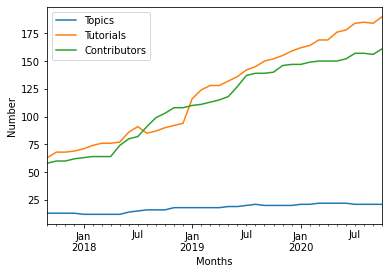

In [39]:
content_stats = (pd.merge(
    global_stats[['Topics', 'Tutorials']],
    contributor_stats,
    left_index=True,
    right_index=True)
    .iloc[13:])
plt.figure()
content_stats.plot()
plt.xlabel('Months')
plt.ylabel('Number')
plt.show()

# Contributions

In [40]:
pr_stats = pd.DataFrame(
    0,
    columns=['PR', 'Reviews and comments (all PR)', 'Reviews and comments (mean per PR)', 'Reviewers (all PR)', 'Reviewers (mean per PR)', 'Duration (all PR)', 'Duration (mean per PR)'],
    index=['PR to add tutorial', 'PR to update tutorial', 'Other PR'])
pr_stats.loc[:, 'Duration (all PR)'] = datetime.timedelta(0)
pr_stats.loc[:, 'Duration (mean per PR)'] = datetime.timedelta(0)
prs = {} # keys: PR number as keys, values: PR object
tuto_prs = {} # Keys: tutorials, values: set of PRs on the tutorial
#n = 1
for pr in repo.get_pulls(state="all"):
    # keep only merged PR
    if not pr.merged:
        continue
    # try to identify PR for new tutorials
    template_pr = False
    status = 'Other PR'
    for l in pr.labels:
        if l.name == 'new tutorial':
            status = 'PR to add tutorial'
    prs[pr.number] = pr
    # to test
    #if n > 100:
    #    break
    #n += 1
    # extract stats
    review_nb = 0
    comment_nb = 0
    reviewers = set()
    for r in pr.get_reviews():
        reviewers.add(r.user.login)
        review_nb += 1
    for r in pr.get_issue_comments():
        reviewers.add(r.user.login)
        comment_nb += 1
    # extract changed files
    update = False
    for f in pr.get_files():
        if 'tutorials' in f.filename:
            # update PR status
            if status == 'Other PR':
                status = 'PR to update tutorial'
            if status != 'PR to add tutorial' and f.status == 'added': 
                if '.md' in f.filename or 'slides.html' in f.filename:
                    status = 'PR to add tutorial'
            # add tutorial to list of changed tutorials
            tuto_n_m = re.search(r'([a-zA-Z0-9\-_]+\/tutorials\/[a-zA-Z0-9\-_]+)', f.filename)
            if tuto_n_m:
                tuto_n = tuto_n_m.group(0)
                tuto_prs.setdefault(tuto_n, set())
                tuto_prs[tuto_n].add(pr.number)
    # add stats
    pr_stats.loc[status, 'PR'] += 1
    pr_stats.loc[status, 'Reviews and comments (all PR)'] += review_nb + comment_nb
    pr_stats.loc[status, 'Reviewers (all PR)'] += len(reviewers)
    pr_stats.loc[status, 'Duration (all PR)'] += (pr.merged_at-pr.created_at)
# compute mean values
pr_stats.loc[:, 'Reviews and comments (mean per PR)'] = pr_stats.loc[:,'Reviews and comments (all PR)']/pr_stats.loc[:, 'PR']
pr_stats.loc[:, 'Reviewers (mean per PR)'] = pr_stats.loc[:,'Reviewers (all PR)']/pr_stats.loc[:, 'PR']
pr_stats.loc[:, 'Duration (mean per PR)'] = pr_stats.loc[:,'Duration (all PR)']/pr_stats.loc[:, 'PR']
# make copy
all_tuto_prs = copy.deepcopy(tuto_prs)

RateLimitExceededException: 403 {"message": "API rate limit exceeded for user ID 1842467.", "documentation_url": "https://docs.github.com/rest/overview/resources-in-the-rest-api#rate-limiting"}

Pull Request statistics

In [ ]:
pr_stats

In [ ]:
tuto_prs = copy.deepcopy(all_tuto_prs)
# merge some tutorials that have been moved / renamed
to_merge = [
    ['admin/tutorials/heterogeneous', 'admin/tutorials/heterogeneous-compute'],
    ['admin/tutorials/monitoring-maintenance', 'admin/tutorials/monitoring'],
    ['Admin-Corner/tutorials/Database_Schema', 'admin/tutorials/database-schema'],
    ['Admin-Corner/tutorials/galaxy_docker', 'admin/tutorials/galaxy-docker'],
    
    ['Assembly/tutorials/debruijn-graph-assembly', 'assembly/tutorials/debruijn-graph-assembly'],
    ['Assembly/tutorials/general-introduction', 'assembly/tutorials/general-introduction'],

    ['chip-seq/tutorials/chip-seq', 'epigenetics/tutorials/estrogen-receptor-binding-site-identification'],
    ['chip-seq/tutorials/ChIPseq', 'epigenetics/tutorials/estrogen-receptor-binding-site-identification'],
    ['chip-seq/tutorials/estrogen-receptor-binding-site-identification', 'epigenetics/tutorials/estrogen-receptor-binding-site-identification'],
    ['chip-seq/tutorials/formation_of_super-structures_on_xi', 'epigenetics/tutorials/formation_of_super-structures_on_xi'],
    ['chip-seq/tutorials/tal1-binding-site-identification', 'epigenetics/tutorials/tal1-binding-site-identification'],
    ['ChIP-Seq/tutorials/ChIPseq', 'epigenetics/tutorials/estrogen-receptor-binding-site-identification'],
    ['ChIP-Seq/tutorials/estrogen_receptor_binding_site_identification', 'epigenetics/tutorials/estrogen-receptor-binding-site-identification'],
    ['ChIP-Seq/tutorials/TAL1_binding_site_identification', 'epigenetics/tutorials/tal1-binding-site-identification'],
    
    ['contributing/tutorials/setup-galaxy-for-training', 'instructors/tutorials/setup-galaxy-for-training'],

    ['Dev-Corner/tutorials/data_source_integration', 'dev/tutorials/data-source-integration'],
    ['Dev-Corner/tutorials/tool_integration', 'dev/tutorials/tool-integration'],
    ['Dev-Corner/tutorials/visualizations', 'dev/tutorials/visualization-generic'],
    ['dev/tutorials/visualization', 'dev/tutorials/visualization-generic'],
    ['dev/tutorials/interactive-environment', 'dev/tutorials/interactive-environments'],
    
    ['Exome-Seq/tutorials/Diploid-variant-calling', 'variant-analysis/tutorials/dip'],
    ['Exome-Seq/tutorials/Exome-Seq', 'variant-analysis/tutorials/exome-seq'],
    
    ['Genome-Annotation/tutorials/general-introduction', 'genome-annotation/tutorials/genome-annotation'],
    
    ['introduction/tutorials/galaxy-intro-collections', 'galaxy-data-manipulation/tutorials/collections'],
    ['introduction/tutorials/galaxy-intro-get-data', 'galaxy-data-manipulation/tutorials/get-data'],
    ['introduction/tutorials/galaxy-intro-rules', 'galaxy-data-manipulation/tutorials/upload-rules'],
    ['introduction/tutorials/galaxy-intro-history', 'galaxy-ui/tutorials/history'],
    ['introduction/tutorials/galaxy-intro-history-to-workflow', 'galaxy-ui/tutorials/history-to-workflow'],
    ['introduction/tutorials/processing-many-samples-at-once', 'galaxy-data-manipulation/tutorials/processing-many-samples-at-once'],
    ['Introduction/tutorials/galaxy-intro-101', 'introduction/tutorials/galaxy-intro-101'],
    ['Introduction/tutorials/galaxy-intro-collections', 'galaxy-data-manipulation/tutorials/collections'],
    ['Introduction/tutorials/galaxy-intro-get-data', 'galaxy-data-manipulation/tutorials/get-data'],
    ['Introduction/tutorials/galaxy-intro-peaks2genes', 'introduction/tutorials/galaxy-intro-peaks2genes'],
    ['Introduction/tutorials/Galaxy101-1', 'introduction/tutorials/galaxy-intro-101'],
    ['Introduction/tutorials/Galaxy101-2', 'introduction/tutorials/galaxy-intro-101'],
    ['Introduction/tutorials/igv', 'introduction/tutorials/igv-introduction'],
    ['Introduction/tutorials/IGV_Introduction', 'introduction/tutorials/igv-introduction'],
    ['Introduction/tutorials/processing_many_samples', 'galaxy-data-manipulation/tutorials/processing-many-samples-at-once'],
    ['Introduction/tutorials/Processing-many-samples-at-once', 'galaxy-data-manipulation/tutorials/processing-many-samples-at-once'],
    ['Introduction/tutorials/workflows', 'galaxy-ui/tutorials/workflow-parameters'],
    
    ['Metagenomics/tutorials/mothur-miseq-sop', 'metagenomics/tutorials/mothur-miseq-sop'],
    
    ['MethylC-Seq/tutorials/methylation-seq', 'epigenetics/tutorials/methylation-seq'],
    ['MethylC-Seq/tutorials/methylc_seq', 'epigenetics/tutorials/methylation-seq'],
    ['MethylC-Seq/tutorials/Methylation-Seq', 'epigenetics/tutorials/methylation-seq'],
    
    ['NGS-QC/tutorials/dive_into_qc', 'sequence-analysis/tutorials/quality-control'],
    
    ['NGS-mapping/tutorials/dive_into_mapping', 'sequence-analysis/tutorials/mapping'],
    
    ['Proteomics/tutorials/WIP_proteinQuant_SIL', 'proteomics/tutorials/protein-quant-sil'],
    ['Proteomics/tutorials/database-handling', 'proteomics/tutorials/database-handling'],
    ['Proteomics/tutorials/labelfree_vs_labelled', 'proteomics/tutorials/labelfree-vs-labelled'],
    ['Proteomics/tutorials/proteinID_SG_PS', 'proteomics/tutorials/protein-id-sg-ps'],
    ['Proteomics/tutorials/proteinQuant_SIL', 'proteomics/tutorials/protein-quant-sil'],
    
    ['RAD-Seq/tutorials/de_novo_rad', 'ecology/tutorials/de-novo-rad-seq'],
    ['RAD-Seq/tutorials/genetic_map_rad', 'ecology/tutorials/genetic-map-rad-seq'],
    ['RAD-Seq/tutorials/ref_based_rad', 'ecology/tutorials/ref-based-rad-seq'],
    
    ['RNA-Seq/tutorials/de_novo', 'transcriptomics/tutorials/de-novo'],
    ['RNA-Seq/tutorials/ref_based', 'transcriptomics/tutorials/ref-based'],
    ['RNA-Seq/tutorials/srna-seq', 'transcriptomics/tutorials/srna'],
    ['RNA-Seq/tutorials/Reference-based-RNA-seq-detailed', 'transcriptomics/tutorials/ref-based'],
    ['RNA-Seq/tutorials/RNA-Seq-hands-on', 'transcriptomics/tutorials/ref-based'],
    
    ['sequence-analysis/tutorials/ref-based-rad-seq', 'ecology/tutorials/ref-based-rad-seq'],
    ['sequence-analysis/tutorials/de-novo-rad-seq', 'ecology/tutorials/de-novo-rad-seq'],
    ['sequence-analysis/tutorials/genetic-map-rad-seq', 'ecology/tutorials/genetic-map-rad-seq'],
    ['sequence-analysis/tutorials/genome-annotation', 'genome-annotation/tutorials/genome-annotation'],
    ['sequence-analysis/tutorials/annotation-with-prokka', 'genome-annotation/tutorials/annotation-with-prokka' ],
    ['sequence-analysis/tutorials/srna', 'transcriptomics/tutorials/srna'],
    
    ['training/tutorials/create-new-tutorial-content', 'contributing/tutorials/create-new-tutorial-content'],
    ['training/tutorials/create-new-tutorial-tours', 'contributing/tutorials/create-new-tutorial-tours'],
    ['training/tutorials/create-new-tutorial-jekyll', 'contributing/tutorials/running-jekyll'],
    
    ['transcriptomics/tutorials/scrna_preprocessing', 'transcriptomics/tutorials/scrna-preprocessing'],
    ['transcriptomics/tutorials/limma-voom', 'transcriptomics/tutorials/rna-seq-counts-to-genes',],
    ['transcriptomics/tutorials/limma-voom_fastqs_to_counts', 'transcriptomics/tutorials/rna-seq-reads-to-counts'],
    
    ['Usegalaxy/tutorials/collections', 'galaxy-data-manipulation/tutorials/collections'],
    ['Usegalaxy/tutorials/dip', 'variant-analysis/tutorials/dip'],
    ['Usegalaxy/tutorials/dunovo', 'variant-analysis/tutorials/dunovo'],
    ['Usegalaxy/tutorials/history', 'galaxy-ui/tutorials/history'],
    ['Usegalaxy/tutorials/ngs', 'introduction/tutorials/galaxy-intro-ngs-data-managment'],
    ['Usegalaxy/tutorials/non_dip', 'variant-analysis/tutorials/non-dip'],
    ['Usegalaxy/tutorials/rb_rnaseq', 'transcriptomics/tutorials/rb-rnaseq'],
    ['usegalaxy/tutorials/collections', 'galaxy-data-manipulation/tutorials/collections'],
    ['usegalaxy/tutorials/dip', 'variant-analysis/tutorials/dip'],
    ['usegalaxy/tutorials/rb-rnaseq', 'transcriptomics/tutorials/rb-rnaseq'],
    ['usegalaxy/tutorials/ngs', 'introduction/tutorials/galaxy-intro-ngs-data-managment'],
    ['usegalaxy/tutorials/dunovo', 'variant-analysis/tutorials/dunovo'],
    ['usegalaxy/tutorials/history', 'galaxy-ui/tutorials/history'],
    ['usegalaxy/tutorials/non-dip', 'variant-analysis/tutorials/non-dip'],

    ['variant-analysis/tutorials/diploid-variant-calling', 'variant-analysis/tutorials/dip'],
]
for t in to_merge:
    tuto_prs[t[1]].update(tuto_prs[t[0]])
    del tuto_prs[t[0]]
    
    
to_remove = [
    'Introduction/tutorials/images',
    'Usegalaxy/tutorials/cp_img',
    'templates/tutorials/tutorial',
    'templates/tutorials/tutorial1',
    
    'Assembly/tutorials/index',
    'Assembly/tutorials/tutorial',
    'Dev-Corner/tutorials/files',
    
    # removed tutorials
    'admin/tutorials/deployment-platforms-options',
    'admin/tutorials/dev-to-production',
    'admin/tutorials/job-conf',
    'admin/tutorials/webservers',
    'admin/tutorials/upstream-auth',
    'Admin-Corner/tutorials/dev_to_production',
    'Admin-Corner/tutorials/mysql_to_postgresql',
    'Admin-Corner/tutorials/setting_up_galaxy_instance',
    'contributing/tutorials/create-new-tutorial-metadata',
    'contributing/tutorials/good-practices',
    'dev/tutorials/github-contribution',
    'introduction/tutorials/galaxy-intro-vis',
    'Introduction/tutorials/galaxy-introduction',
    'Introduction/tutorials/galaxy-intro-vis',
    'Introduction/tutorials/introduction_my_first_analysis',
    'Introduction/tutorials/Introduction',
    'Introduction/tutorials/Introduction_to_Galaxy_Uni',
    'metabolomics/tutorials/lcms-data-import',
    'training/tutorials/create-new-tutorial-docker', 
    'training/tutorials/create-new-tutorial-metadata', 
    'training/tutorials/good-practices', 
]
for t in to_remove:
    del tuto_prs[t]
    
list(tuto_prs.keys())
len(tuto_prs.keys())

Statistics per tutorials

In [ ]:
tuto_pr_stats = pd.DataFrame(
    0,
    columns=['Creation', 'PR', 'Mean duration between PRs'],
    index=[])
for t in tuto_prs:
    tuto_pr_stats.loc[t, 'PR'] = len(tuto_prs[t])
    #tuto_pr_stats.loc[t, 'Commits'] = repo.get_commits(path = t).totalCount
    # extract mean duration by sorting PRs and compute time between merge and creation
    ordered_prs = sorted(tuto_prs[t])
    tuto_pr_stats.loc[t, 'Creation'] = prs[ordered_prs[0]].merged_at
    prev_pr_merged_at = prs[ordered_prs[0]].merged_at
    duration = datetime.timedelta(0)
    pr_n = 0
    for pr in ordered_prs[1:]:
        d = prs[pr].created_at - prev_pr_merged_at
        # keep only positive delta
        if d < datetime.timedelta(0):
            continue
        pr_n += 1
        duration += d
        prev_pr_merged_at = prs[pr].merged_at
    if pr_n > 0:
        tuto_pr_stats.loc[t, 'Mean duration between PRs'] = duration/pr_n
    else:
        tuto_pr_stats.loc[t, 'Mean duration between PRs'] = datetime.timedelta(0)
tuto_pr_stats.loc[:, 'PR'] = tuto_pr_stats.loc[:, 'PR'].astype(int)
tuto_pr_stats = (tuto_pr_stats
    .sort_values('PR',ascending=False))

Top 10 tutorials in terms of PR

In [ ]:
tuto_pr_stats.head(12)

Mean number PR and commits per tutorials

In [ ]:
tuto_pr_stats.mean()

Mean duration between PRs

In [ ]:
str(tuto_pr_stats.loc[:,'Mean duration between PRs'].sum()/tuto_pr_stats.shape[0])